# belief testing

rendere il belief indipendente dalla posizione e orientazione del robot, dipenderò unicamente dalla deformazione

$$b(s=((x,y,phi),theta)) = b(theta) * \delta(xyphi = real(xyphi))$$

real(xyphi) = x*
from now on x = xyphi


## belief update 

$$b'_{a,o}(x',\theta') = \eta \cdot \delta(x'=x^*+a) \cdot p(o|x',\theta') \cdot \sum_{x,\theta}p(x',\theta'|x,\theta,a)b(x,\theta)$$
$$ = \eta \cdot \delta(x'=x^*+a) \cdot p(o|x',\theta') \cdot b(x'-a,\theta') $$
$$ = \eta \cdot \delta(x'=x^*+a) \cdot p(o|x',\theta') \cdot \delta (x'-a = x^* )b(\theta') $$
$$ = \eta \cdot \delta(x'=x^*+a) \cdot p(o|x',\theta') \cdot b(\theta') $$

dunque a seconda della azione scelta i non zero saranno i 4 x raggiungibili con a

$$p(o|b,a) = \sum_{x,\theta}p(o|x,\theta)b(x.\theta)$$
$$ = \sum_{\theta}p(o|x^*,\theta)b(\theta)$$

immagino la struttura di input per la rete come qualcosa del tipo x,y,phi,b(theta)=[b(theta1),b(theta2),b(theta3),b(theta4)]

è vero che possiamo rendere indipendenti pos e theta per le transizioni, ma non per le osservazioni né per il reward

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
from tqdm import trange

from agents.dqn import DoubleDQNAgent, QNetwork
from environment.env import GridEnvDeform, POMDPWrapper_v0
import matplotlib.pyplot as plt
from utils.belief import update_belief, belief_entropy



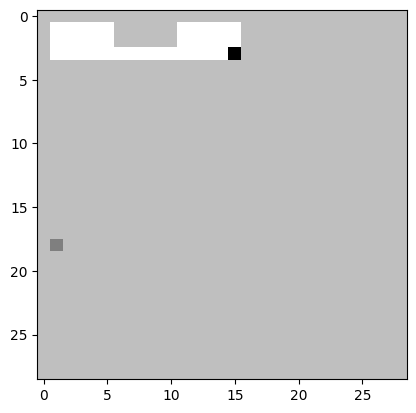

In [2]:
# maze size
N = 2

# thetas deformations (range(a,b),range(c,d))
l0 = 1
h0 = 10
l1 = 1
h1 = 10

maze = np.load(f"maze/maze_{N}.npy")
env = GridEnvDeform(maze,l0,h0,l1,h1)
env.render()

states = [((x,y,phi),(i,j)) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4) for i in range(l0,h0) for j in range(l1,h1)] 
positions = [(x,y,phi) for x in range(1,env.max_shape[0]-1) for y in range(1,env.max_shape[1]-1) for phi in range(4)]
actions = [0,1,2,3]
obs = list(itertools.product([0,1], repeat=5))
thetas = [(i,j) for i in range(l0,h0) for j in range(l1,h1)]

state_dict = {state: i for i, state in enumerate(states)}
position_dict = {position: i for i, position in enumerate(positions)}
obs_dict = {obs : i for i, obs in enumerate(obs)}

# Actions are: 0-listen, 1-open-left, 2-open-right
lenS = len(states)
lenP = len(positions)
lenA = len(actions)
lenO = len(obs)


In [3]:
def b_theta_update(belief,pos,observation):
    """
    perform update over theta
    
    $$b'_{x,a,o}(theta) = \eta \cdot p(o|x,theta) \cdot b(theta)$$
    
    """

    new_belief = torch.zeros_like(belief)

    for t, theta in enumerate(env.deformations):
        P_o_s_theta = np.all(env.get_observation((pos,theta)) == observation) # 0 or 1 

        new_belief[t] = P_o_s_theta * belief[t]
    
    new_belief = new_belief / (torch.sum(new_belief) + 1e-10)

    return new_belief

# Infotxis

In [120]:
import time

class ThetaInfotaxis():
  
    def __init__(self, env: GridEnvDeform):
        self.env = env    
    
    def get_entropy(self, probabilities):
        
        # Calculate entropy, avoiding log(0) by adding a mask
        entropy = -torch.sum(probabilities * torch.log2(probabilities + (probabilities == 0).float()))
        
        return entropy.item()  # .item() to get a standard Python float

    def update_belief(self, belief, pos, observation):
        """"
        perform update over theta
        
        $$b'_{x,a,o}(theta) = \eta \cdot p(o|x,theta) \cdot b(theta)$$
        
        """

        new_belief = torch.zeros_like(belief)

        for t, theta in enumerate(self.env.deformations):
            P_o_s_theta = np.all(self.env.get_observation(s = (pos,theta)) == observation) # 0 or 1 

            new_belief[t] = P_o_s_theta * belief[t]
        
        new_belief = new_belief / (torch.sum(new_belief) + 1e-10)

        return new_belief
    
    def G(self,b,pos):
        """"
        
        input:
        b: belief
        a: action

        output: 
        G: torch.tensor shape (numactions) expected reduction of the belief's entropy G (b, a)
        
        
        G(b,a) = H(b) - sum_o P(o|b,a)H(b|a,o)
        P(o|b,a) = sum_s P(o|s,a)P(s|b,a) = sum_theta P(o|s=(pos,theta),a)b(theta)
        
        """
        # H(b) = entropy of belief
        H_b = self.get_entropy(b)
                
        # this is P_o_b_a = P(o|b) = sum_s P(o|s=(pos,theta)) * b(theta) = sum_theta P(o|s=(pos,theta)) * b(theta) 
        # P_o_x_t]_o_t = P(o|s=(pos,t)) shape (numobservations,)
        P_o_x_t = torch.zeros((32,))
        for o, obs in enumerate(self.env.obs):
            for t, theta in enumerate(self.env.deformations):
                P_o_x_t[o] += 1*np.all(self.env.get_observation(s = (pos,theta)) == obs) * b[t]


        # updated_belief b_a_o = b(theta) * P(o|s=(pos+a,theta))
        # b_a_o]_a_o_t = b'_a_o(t) shape (numactions,numobservations,numdeformations)
        b_a_o = torch.zeros((len(self.env.actions),len(self.env.obs), len(self.env.deformations)))
        for a, action in enumerate(self.env.actions):
            next_pos = self.env.next_state(a,pos)
            for o, obs in enumerate(self.env.obs):
                b_a_o[a][o] = self.update_belief(b,next_pos,obs)

        # # [H_b_a_o]_i = H(b|a,o_i) = entropy of updated belief shape (numactions, numobservations)
        H_b_a_o = -torch.sum(b_a_o * torch.log2(b_a_o + (b_a_o == 0).float()), dim=2)

        G = H_b - torch.einsum('o,ao->a', P_o_x_t, H_b_a_o)

        return G

    def get_action(self, belief, pos):
        """
        Compute the action that minimizes the expected entropy of the belief.

        Parameters:
            belief (torch.Tensor): The current belief over states, shape (num_states,)

        Returns:
            int: The action that minimizes the expected entropy of the belief
        """
        # Compute the expected entropy reduction for each action
        G = self.G(belief,pos)
                      
        # Return the action that minimizes the expected entropy
        return torch.argmax(G).item()


agent = ThetaInfotaxis(env)


In [121]:
pos = (1,1,0)
theta = (1,1)
belief = torch.ones(len(env.deformations)) / len(env.deformations)
ob = [0,0,0,0,0]


state ((24, 15, 2), (5, 2))
Best action:  3


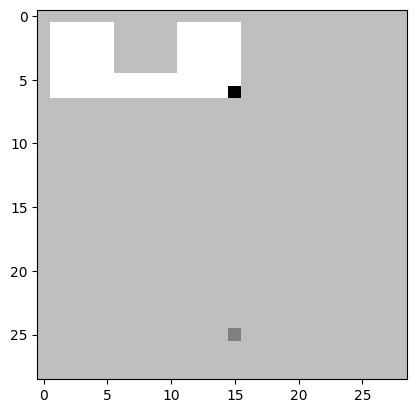

Total reward:     -2.0  
next State:  ((25, 15, 2), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0132)
Belief entropy:  6.247928142547607



state ((25, 15, 2), (5, 2))
Best action:  1


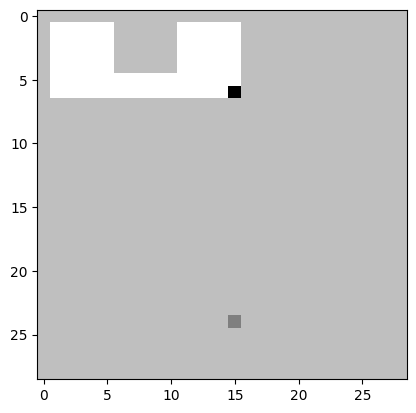

Total reward:     -4.0  
next State:  ((24, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0141)
Belief entropy:  6.149746894836426



state ((24, 15, 0), (5, 2))
Best action:  0


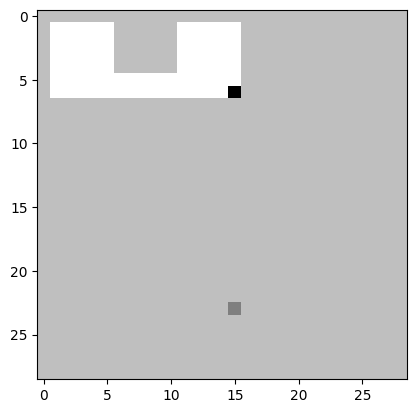

Total reward:     -6.0  
next State:  ((23, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0141)
Belief entropy:  6.149747848510742



state ((23, 15, 0), (5, 2))
Best action:  0


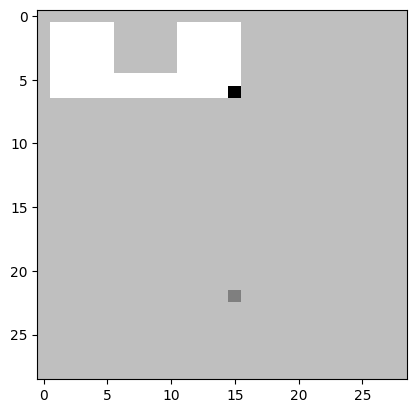

Total reward:     -8.0  
next State:  ((22, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  6.044393539428711



state ((22, 15, 0), (5, 2))
Best action:  0


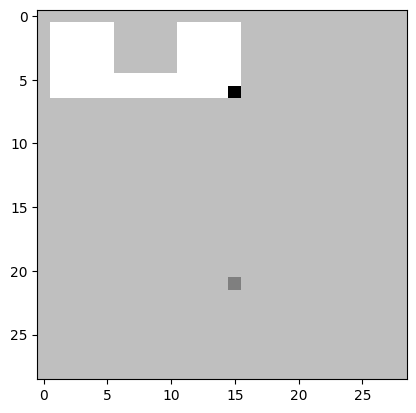

Total reward:     -10.0  
next State:  ((21, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  6.044393539428711



state ((21, 15, 0), (5, 2))
Best action:  0


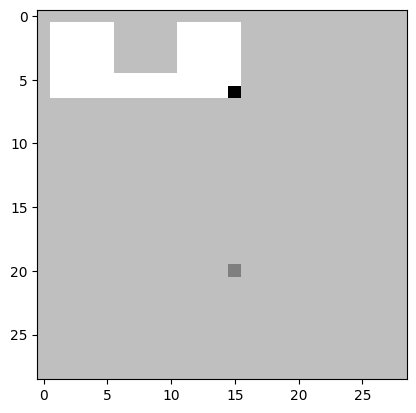

Total reward:     -12.0  
next State:  ((20, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0152)
Belief entropy:  6.044393539428711



state ((20, 15, 0), (5, 2))
Best action:  0


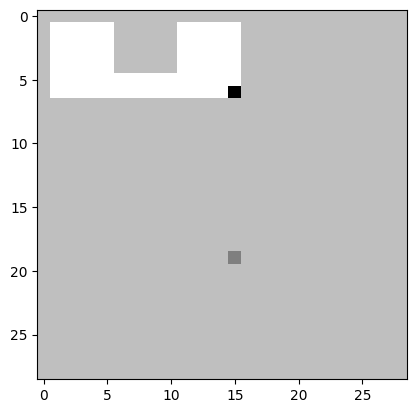

Total reward:     -14.0  
next State:  ((19, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0164)
Belief entropy:  5.930737018585205



state ((19, 15, 0), (5, 2))
Best action:  0


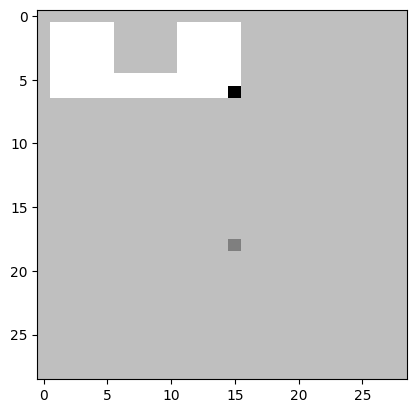

Total reward:     -16.0  
next State:  ((18, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0164)
Belief entropy:  5.930737018585205



state ((18, 15, 0), (5, 2))
Best action:  0


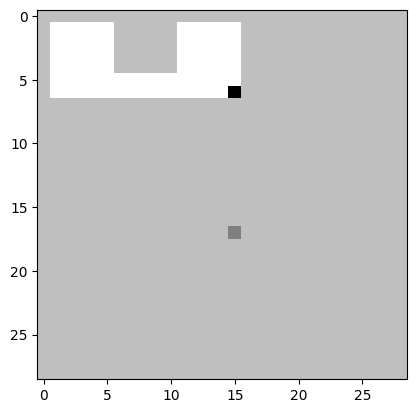

Total reward:     -18.0  
next State:  ((17, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0164)
Belief entropy:  5.930737018585205



state ((17, 15, 0), (5, 2))
Best action:  0


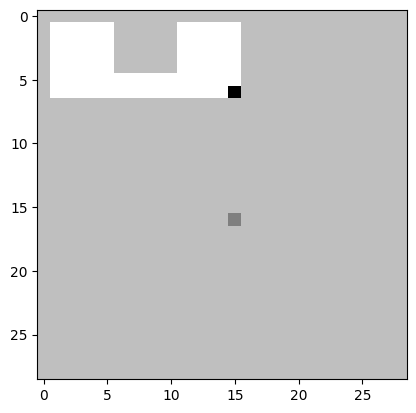

Total reward:     -20.0  
next State:  ((16, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0179)
Belief entropy:  5.8073554039001465



state ((16, 15, 0), (5, 2))
Best action:  0


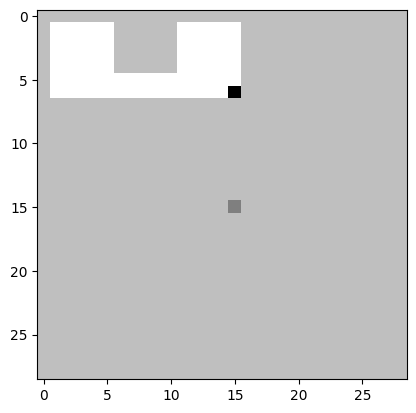

Total reward:     -22.0  
next State:  ((15, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0179)
Belief entropy:  5.8073554039001465



state ((15, 15, 0), (5, 2))
Best action:  0


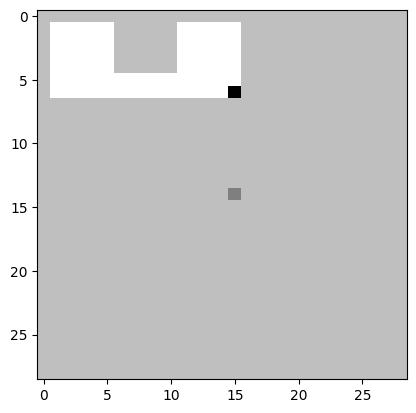

Total reward:     -24.0  
next State:  ((14, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0179)
Belief entropy:  5.8073554039001465



state ((14, 15, 0), (5, 2))
Best action:  0


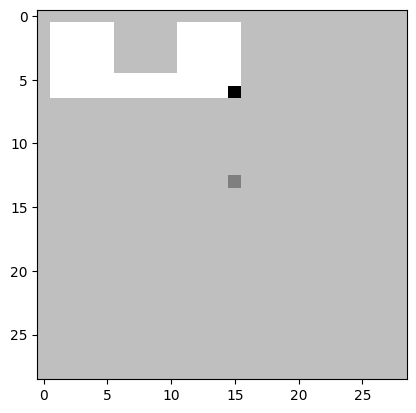

Total reward:     -26.0  
next State:  ((13, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0196)
Belief entropy:  5.672425746917725



state ((13, 15, 0), (5, 2))
Best action:  0


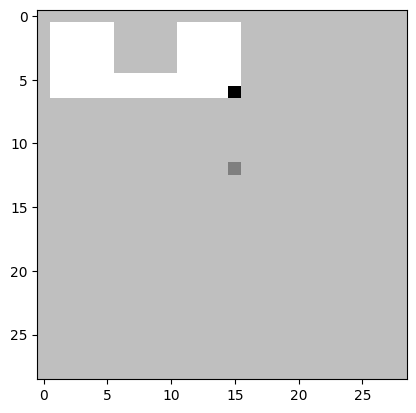

Total reward:     -28.0  
next State:  ((12, 15, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0196)
Belief entropy:  5.672425746917725



state ((12, 15, 0), (5, 2))
Best action:  0


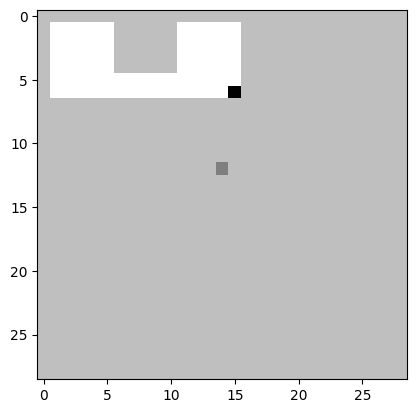

Total reward:     -30.0  
next State:  ((12, 14, 3), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0196)
Belief entropy:  5.672425746917725



state ((12, 14, 3), (5, 2))
Best action:  0


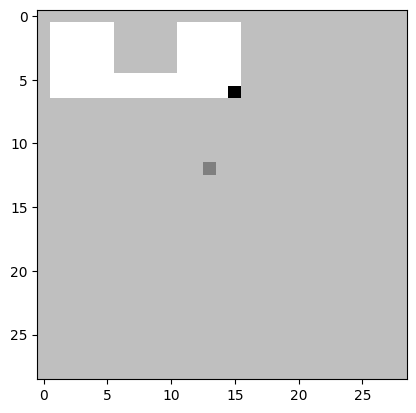

Total reward:     -32.0  
next State:  ((12, 13, 3), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0222)
Belief entropy:  5.491853713989258



state ((12, 13, 3), (5, 2))
Best action:  0


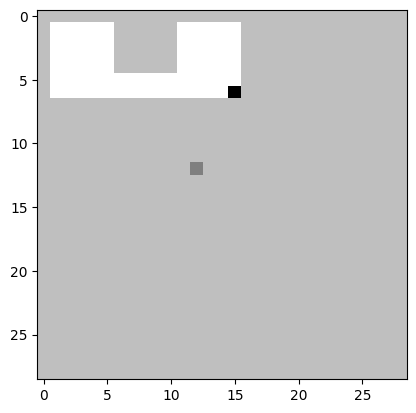

Total reward:     -34.0  
next State:  ((12, 12, 3), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0222)
Belief entropy:  5.491853713989258



state ((12, 12, 3), (5, 2))
Best action:  0


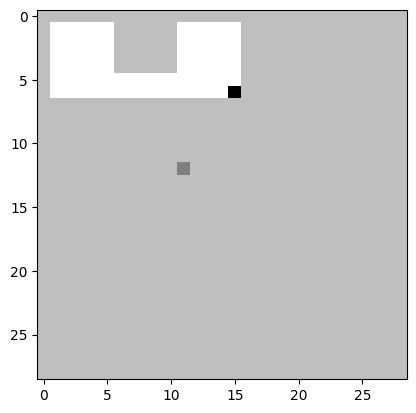

Total reward:     -36.0  
next State:  ((12, 11, 3), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0222)
Belief entropy:  5.491853713989258



state ((12, 11, 3), (5, 2))
Best action:  0


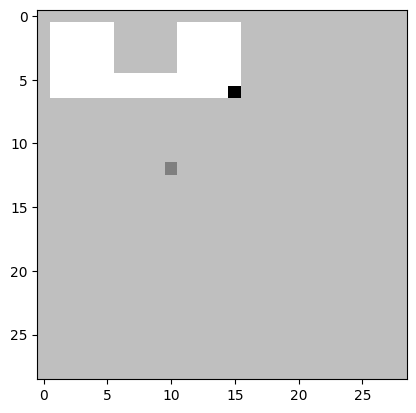

Total reward:     -38.0  
next State:  ((12, 10, 3), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0256)
Belief entropy:  5.285402297973633



state ((12, 10, 3), (5, 2))
Best action:  0


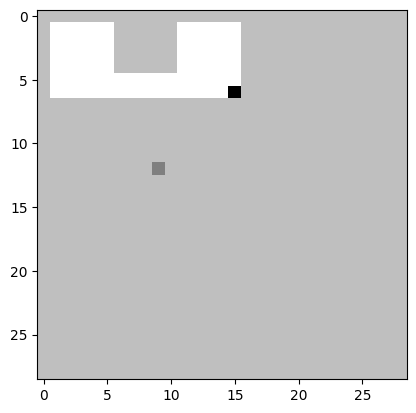

Total reward:     -40.0  
next State:  ((12, 9, 3), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0256)
Belief entropy:  5.285402297973633



state ((12, 9, 3), (5, 2))
Best action:  0


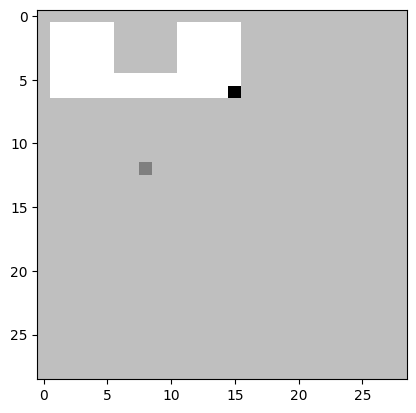

Total reward:     -42.0  
next State:  ((12, 8, 3), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0256)
Belief entropy:  5.285402297973633



state ((12, 8, 3), (5, 2))
Best action:  0


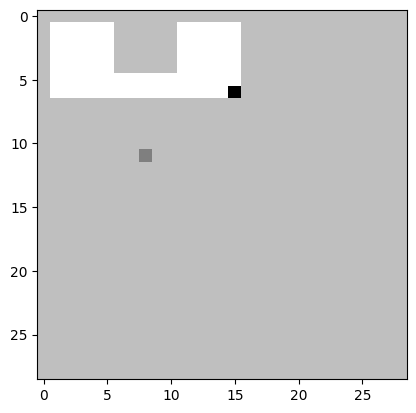

Total reward:     -44.0  
next State:  ((11, 8, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0256)
Belief entropy:  5.285402297973633



state ((11, 8, 0), (5, 2))
Best action:  0


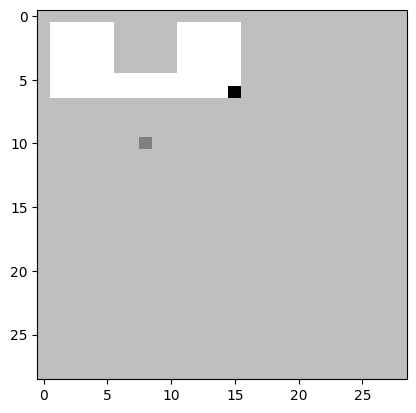

Total reward:     -46.0  
next State:  ((10, 8, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0312)
Belief entropy:  5.0



state ((10, 8, 0), (5, 2))
Best action:  3


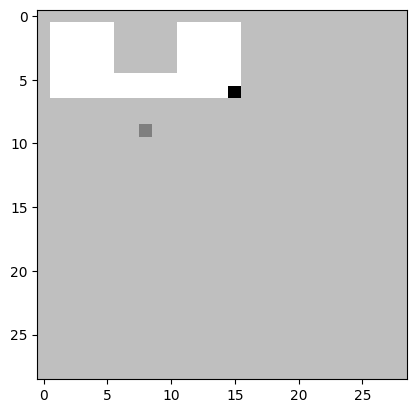

Total reward:     -48.0  
next State:  ((9, 8, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0312)
Belief entropy:  5.0



state ((9, 8, 0), (5, 2))
Best action:  3


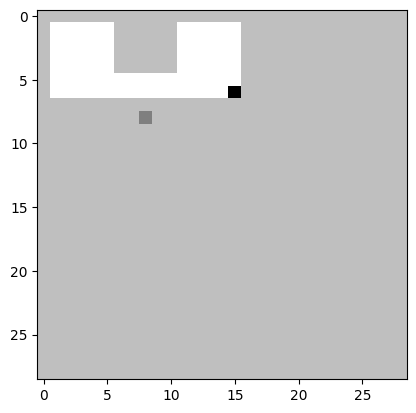

Total reward:     -50.0  
next State:  ((8, 8, 0), (5, 2))
argmax and max Belief:  (1, 1) tensor(0.0312)
Belief entropy:  5.0





In [123]:

s, _ = env.reset()
b = torch.ones(len(thetas)) / len(thetas)
t = np.random.randint(len(thetas))

horizon = 250

totalReward = 0.0

for t in range(horizon - 1, -1, -1):

    best_action = agent.get_action(b,s[0])

    print("state", s)
    print("Best action: ", best_action)
    # input from command line best action
    best_action = int(input("Enter action: "))
    next_state, reward, done, _, info = env.step(best_action, s, execute=True)
    next_obs = env.get_observation()
    env.render()


    totalReward += reward
    next_belief = b_theta_update(b,next_state[0], next_obs)
    
    print("Total reward:     " + str(totalReward) + "  ")
    print("next State: ", next_state)
    print("argmax and max Belief: ", thetas[torch.argmax(next_belief)], torch.max(next_belief))
    print("Belief entropy: ", agent.get_entropy(next_belief))

    print("\n\n")

    # if t == 1:
    #     assert states[torch.argmax(next_belief)] == states[next_state] 
    
    # Then we update the world
    s = next_state
    b = next_belief
    # Sleep 1 second so the user can see what is happening.



In [126]:
b

tensor([0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0312, 0.0312, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0312, 0.0312, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0312, 0.0312, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0312, 0.0312, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0312, 0.0312, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0312, 0.0312, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

# QMDP tabular

In [4]:
# import the MDP solution model (tabular q in this case)
Q = np.load(f"agents/tabularQ_maze_{N}_10deformations.npy")

In [5]:
import time
def eval_qmdp_tabular(env : GridEnvDeform, Q, num_episodes=100, max_episode_steps=25, render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()

        obs = env.get_observation()

        b_0 = torch.ones(len(thetas)) / len(thetas)   
        b = b_theta_update(b_0,s[0], obs)

        print("Actual State: ", s)
        print("observation: ", obs) 
        print("argmax and max Belief: ", states[torch.argmax(b)], torch.max(b))
        # print("Belief entropy: ", belief_entropy(b))


        episode_reward = 0
        done = False
        c = max_episode_steps
        while not done and c > 0:
            if render:
                env.render_bis()
                time.sleep(1)

            pos = s[0]
            theta = thetas[torch.argmax(b)]
            argmaxstate = state_dict[(pos,theta)]

            # Agent takes an action using a greedy policy (without exploration)
            action = np.argmax(Q[argmaxstate])
            next_state, reward, done, _, info = env.step(action.item(), s, execute=render)
            
            s = next_state
            next_obs = env.get_observation(next_state)

            b_prime = b_theta_update(b,s[0], next_obs)
            b = b_prime

            episode_reward += reward
            
            print("Chosen action: ", action)
            print("Actual State: ", next_state)
            print("argmaxstate", states[argmaxstate])
            print("argmax and max Belief: ", thetas[torch.argmax(b_prime)], torch.max(b_prime))
            # print("Belief entropy: ", belief_entropy(b_prime))


            if done or c == 1:
                total_rewards.append(episode_reward)
                if done:
                    env.render_bis()
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    print(b)
    return avg_reward

In [11]:
env.set_rendering()
eval_qmdp_tabular(env, Q, num_episodes=1,max_episode_steps=25, render=True)
env.close_render()

Actual State:  ((26, 15, 3), (8, 2))
observation:  [1 1 1 1 1]
argmax and max Belief:  ((1, 1, 0), (1, 1)) tensor(0.0132)
Chosen action:  0
Actual State:  ((26, 14, 3), (8, 2))
argmaxstate ((26, 15, 3), (1, 1))
argmax and max Belief:  (1, 1) tensor(0.0132)
Chosen action:  3
Actual State:  ((27, 14, 2), (8, 2))
argmaxstate ((26, 14, 3), (1, 1))
argmax and max Belief:  (1, 1) tensor(0.0132)
Chosen action:  1
Actual State:  ((27, 13, 3), (8, 2))
argmaxstate ((27, 14, 2), (1, 1))
argmax and max Belief:  (1, 1) tensor(0.0133)
Chosen action:  3
Actual State:  ((27, 13, 2), (8, 2))
argmaxstate ((27, 13, 3), (1, 1))
argmax and max Belief:  (1, 1) tensor(0.0133)
Chosen action:  0
Actual State:  ((27, 13, 2), (8, 2))
argmaxstate ((27, 13, 2), (1, 1))
argmax and max Belief:  (1, 1) tensor(0.0133)
Chosen action:  0
Actual State:  ((27, 13, 2), (8, 2))
argmaxstate ((27, 13, 2), (1, 1))
argmax and max Belief:  (1, 1) tensor(0.0133)
Chosen action:  0
Actual State:  ((27, 13, 2), (8, 2))
argmaxstate (

# Information Directed Sampling IDS

In [12]:
class IDS():
  
    def __init__(self, env: GridEnvDeform):
        self.env = env    
    
    def get_entropy(self, probabilities):
        
        # Calculate entropy, avoiding log(0) by adding a mask
        entropy = -torch.sum(probabilities * torch.log2(probabilities + (probabilities == 0).float()))
        
        return entropy.item()  # .item() to get a standard Python float

    def update_belief(self, belief, pos, observation):
        """"
        perform update over theta
        
        $$b'_{x,a,o}(theta) = \eta \cdot p(o|x,theta) \cdot b(theta)$$
        
        """

        new_belief = torch.zeros_like(belief)

        for t, theta in enumerate(self.env.deformations):
            P_o_s_theta = np.all(self.env.get_observation(s = (pos,theta)) == observation) # 0 or 1 

            new_belief[t] = P_o_s_theta * belief[t]
        
        new_belief = new_belief / (torch.sum(new_belief) + 1e-10)

        return new_belief
    
    def G(self,b,pos):
        """"
        
        input:
        b: belief
        pos: actual position (known)
        
        output: 
        G: torch.tensor shape (numactions) expected reduction of the belief's entropy G(b, a)
        
        
        G(b,a) = H(b) - sum_o P(o|b,a)H(b|a,o)
        P(o|b,a) = sum_s P(o|s,a)P(s|b,a) = sum_theta P(o|s=(pos,theta),a)b(theta)
        
        """
        # H(b) = entropy of belief
        H_b = self.get_entropy(b)
                
        # this is P_o_b_a = P(o|b) = sum_s P(o|s=(pos,theta)) * b(theta) = sum_theta P(o|s=(pos,theta)) * b(theta) 
        # P_o_x_t]_o_t = P(o|s=(pos,t)) shape (numobservations,)
        P_o_x_t = torch.zeros((32,))
        for o, obs in enumerate(self.env.obs):
            for t, theta in enumerate(self.env.deformations):
                P_o_x_t[o] += 1*np.all(self.env.get_observation(s = (pos,theta)) == obs) * b[t]


        # updated_belief b_a_o = b(theta) * P(o|s=(pos+a,theta))
        # b_a_o]_a_o_t = b'_a_o(t) shape (numactions,numobservations,numdeformations)
        b_a_o = torch.zeros((len(self.env.actions),len(self.env.obs), len(self.env.deformations)))
        for a, action in enumerate(self.env.actions):
            next_pos = self.env.next_state(a,pos)
            for o, obs in enumerate(self.env.obs):
                b_a_o[a][o] = self.update_belief(b,next_pos,obs)

        # # [H_b_a_o]_i = H(b|a,o_i) = entropy of updated belief shape (numactions, numobservations)
        H_b_a_o = -torch.sum(b_a_o * torch.log2(b_a_o + (b_a_o == 0).float()), dim=2)

        G = H_b - torch.einsum('o,ao->a', P_o_x_t, H_b_a_o)

        return G

    def Delta(self,b,pos):
        """compute expected regret for each action
        
        \Delta = max_a(\sum_s R(s,a)b(s))-\sum_s R(s,a)b(s)
        """

        # R(s,a) = 1 if s is the goal state, 0 otherwise
        R_t_a = torch.zeros(len(self.env.deformations),len(self.env.actions))
        for t, theta in enumerate(self.env.deformations):
            for a, action in enumerate(self.env.actions):
                R_t_a[t][a] = env.R((pos,theta),a)
        
        E_R = torch.einsum('ta,t->a',R_t_a,b)

        # expected regret for each action
        Delta = torch.max(E_R) - E_R

        return Delta

    def IDS_action(self, belief,pos):
        """
        Compute the distribution over actions that minimizes ratio of the expected reduction of the belief's entropy and the expected regret
        
        pi = argmin_pi (delta(pi) / G(pi))
        where
        delta(pi) = sum_a pi(a) * delta(a)
        G(pi) = sum_a pi(a) * G(a)
        """
        
        G_a = self.G(belief,pos)
        Delta_a = self.Delta(belief,pos)

        q = torch.zeros((len(self.env.actions),len(self.env.actions)))
        for a in range(len(self.env.actions)):
            for aa in range(a, len(self.env.actions)):                
                q[a][aa] = self._q_a_aa(a,aa, Delta_a,G_a) 

        tmp = self._aastar(q,Delta_a,G_a)        
        astar, astarstar = tmp[0], tmp[1]
        
        # sample form a bernoulli distribution with parameter q
        b = torch.bernoulli(q[astar,astarstar])        
        return b*astar + (1-b)*astarstar

    def _q_a_aa(self,a,aa,Delta,G):
        """compute the argmin"""

        q = torch.tensor(np.linspace(0, 1, 100))
        ratio = torch.square(q*Delta[a] + (1-q) * Delta[aa]) / (q*G[a] + (1-q) * G[aa])
        return q[np.argmin(ratio)]
    
    def _aastar(self,q,Delta,G):
        """compute the argmin"""

        ratio = torch.zeros((len(self.env.actions),len(self.env.actions)))
        for a in range(len(self.env.actions)):
            for aa in range(a, len(self.env.actions)):

                ratio[a,aa] = torch.square(q[a,aa]*Delta[a] + (1-q[a,aa]) * Delta[aa]) / (q[a,aa]*G[a] + (1-q[a,aa]) * G[aa])

        minindex = torch.argmin(ratio)
        return torch.unravel_index(minindex, ratio.shape)
    
agent = IDS(env)


In [17]:
env.set_rendering()

s, _ = env.reset()
b = torch.ones(len(thetas)) / len(thetas)
t = np.random.randint(len(thetas))

horizon = 25

totalReward = 0.0

for t in range(horizon - 1, -1, -1):

    best_action = int(agent.IDS_action(b,s[0]).item())

    print("state", s)
    print("Best action: ", best_action)
    # input from command line best action
    # best_action = int(input("Enter action: "))
    next_state, reward, done, _, info = env.step(best_action, s, execute=True)
    next_obs = env.get_observation()
    env.render_bis()


    totalReward += reward
    next_belief = b_theta_update(b,next_state[0], next_obs)
    
    print("Total reward:     " + str(totalReward) + "  ")
    print("next State: ", next_state)
    print("argmax and max Belief: ", thetas[torch.argmax(next_belief)], torch.max(next_belief))
    print("Belief entropy: ", agent.get_entropy(next_belief))

    print("\n\n")

    # if t == 1:
    #     assert states[torch.argmax(next_belief)] == states[next_state] 
    
    # Then we update the world
    s = next_state
    b = next_belief
    # Sleep 1 second so the user can see what is happening.



state ((16, 12, 2), (6, 4))
Best action:  2
Total reward:     -2.0  
next State:  ((15, 12, 0), (6, 4))
argmax and max Belief:  (1, 1) tensor(0.0175)
Belief entropy:  5.832890510559082



state ((15, 12, 0), (6, 4))
Best action:  0
Total reward:     -4.0  
next State:  ((14, 12, 0), (6, 4))
argmax and max Belief:  (1, 1) tensor(0.0175)
Belief entropy:  5.832890510559082



state ((14, 12, 0), (6, 4))
Best action:  0
Total reward:     -6.0  
next State:  ((13, 12, 0), (6, 4))
argmax and max Belief:  (5, 4) tensor(0.2000)
Belief entropy:  2.321928024291992



state ((13, 12, 0), (6, 4))
Best action:  0
Total reward:     -6.5  
next State:  ((12, 12, 0), (6, 4))
argmax and max Belief:  (5, 4) tensor(0.2000)
Belief entropy:  2.321928024291992



state ((12, 12, 0), (6, 4))
Best action:  0
Total reward:     -7.0  
next State:  ((11, 12, 0), (6, 4))
argmax and max Belief:  (5, 4) tensor(0.2000)
Belief entropy:  2.321928024291992



state ((11, 12, 0), (6, 4))
Best action:  0
Total reward:   

# DQN 

In [4]:
agent = DoubleDQNAgent(5,4)
agent.load("agents/double_dqn_maze_2_10deformations.pt")

/home/flaccagora/Desktop/RoboSurgery/src/agents/dqn.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.q_network.load_state_dict(torch.load(path))


In [5]:
def evaluate_agent_training(env : GridEnvDeform, agent : DoubleDQNAgent, num_episodes=10,render=False):
    total_rewards = []

    for episode in range(num_episodes):
        s, _ = env.reset()
        state = torch.tensor([item for sublist in s for item in sublist], dtype=torch.float32)
        
        obs = env.get_observation()

        b_0 = torch.ones(len(thetas)) / len(thetas)   
        b = b_theta_update(b_0,s[0], obs)
    
        episode_reward = 0
        done = False
        c = 25
        while not done and c > 0:
            # Render the environment
            if render:
                env.render()                                
            
            
            pos = s[0]
            theta = thetas[torch.argmax(b)]
            argmaxstate = (pos,theta)
            maxstate = torch.tensor([item for sublist in argmaxstate for item in sublist], dtype=torch.float32)

            # Agent takes an action using a greedy policy (without exploration)
            action = agent.choose_deterministic_action(maxstate)
            next_state, reward, done, _, info = env.step(action,s,execute=render)

            next_obs = env.get_observation(next_state)
            s = next_state

            b_prime = b_theta_update(b,s[0], next_obs)
            b = b_prime

            if render:
                print("State: ", s)
                print("Chosen action: ", action)
                print("Next state: ", next_state)
                print("argmaxstate", argmaxstate)
                print("argmax and max Belief: ", thetas[torch.argmax(b_prime)], torch.max(b_prime))
                
            episode_reward += reward
            
            if done or c == 1:
                total_rewards.append(episode_reward)
                # print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}")

            c -= 1
    avg_reward = np.mean(total_rewards)
    # print(f"Average Reward over {num_episodes} episodes: {avg_reward}")
    return avg_reward


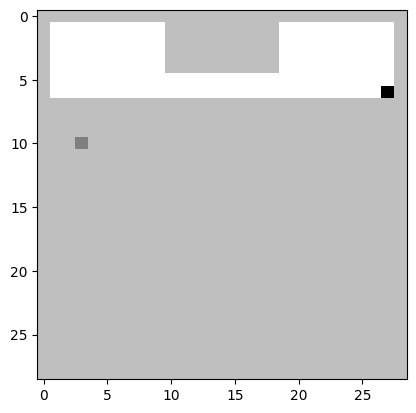

State:  ((9, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((9, 3, 0), (9, 2))
argmaxstate ((10, 3, 0), (1, 1))
argmax and max Belief:  (1, 1) tensor(0.0556)


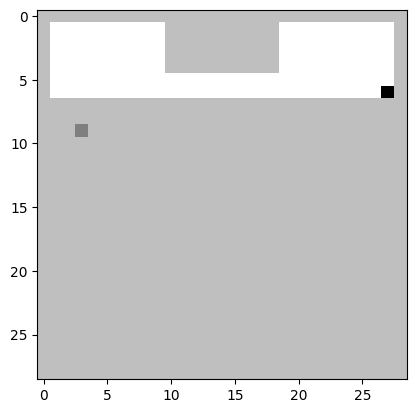

State:  ((8, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((8, 3, 0), (9, 2))
argmaxstate ((9, 3, 0), (1, 1))
argmax and max Belief:  (1, 1) tensor(0.0556)


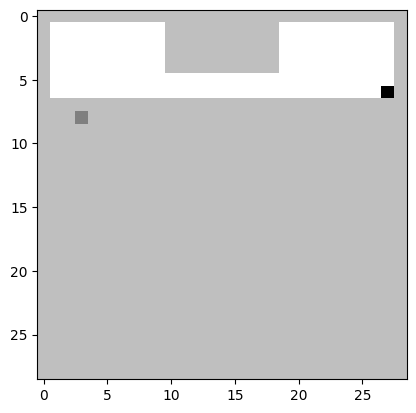

State:  ((7, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((7, 3, 0), (9, 2))
argmaxstate ((8, 3, 0), (1, 1))
argmax and max Belief:  (2, 2) tensor(0.1250)


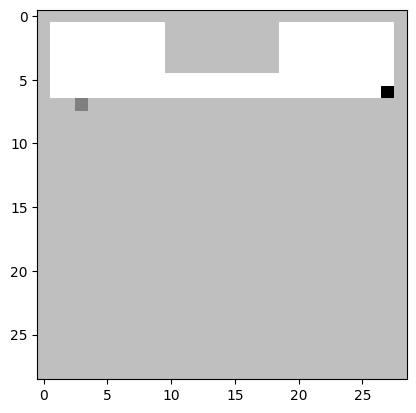

State:  ((6, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((6, 3, 0), (9, 2))
argmaxstate ((7, 3, 0), (2, 2))
argmax and max Belief:  (2, 2) tensor(0.1250)


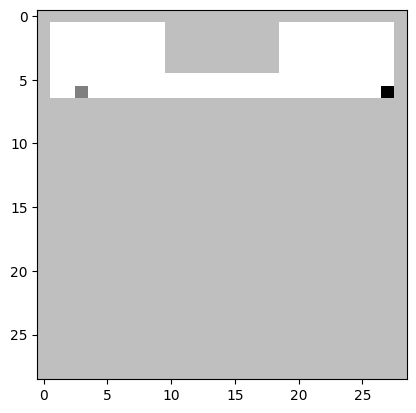

State:  ((5, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((5, 3, 0), (9, 2))
argmaxstate ((6, 3, 0), (2, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


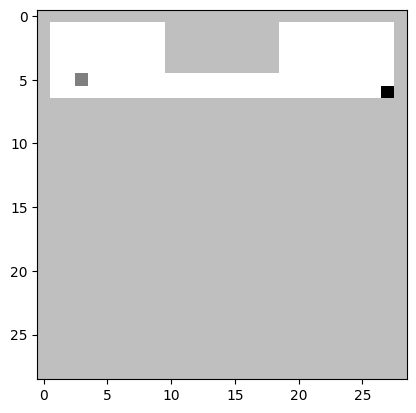

State:  ((4, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((4, 3, 0), (9, 2))
argmaxstate ((5, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


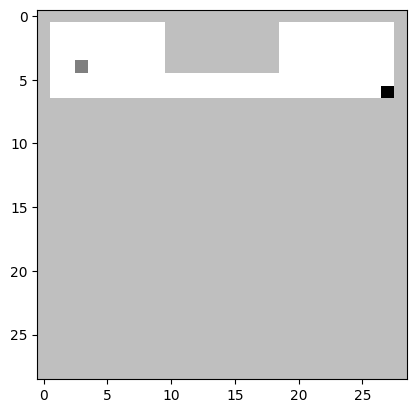

State:  ((3, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((3, 3, 0), (9, 2))
argmaxstate ((4, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


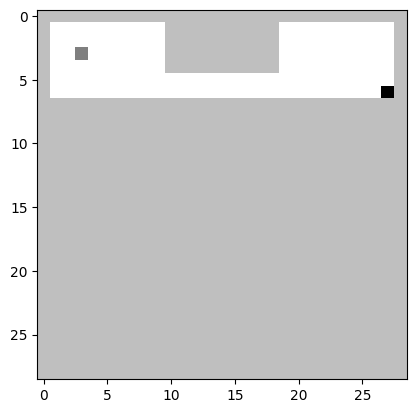

State:  ((2, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((2, 3, 0), (9, 2))
argmaxstate ((3, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


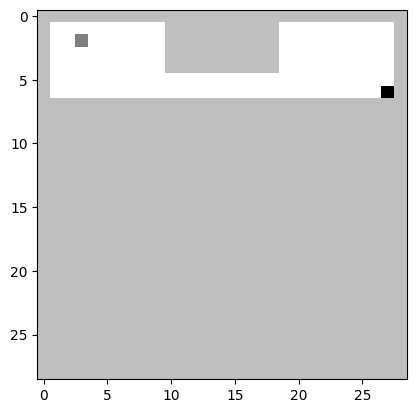

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((2, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


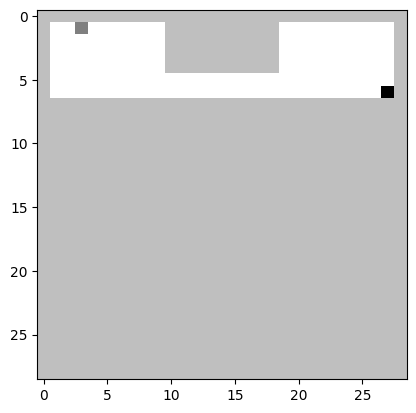

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


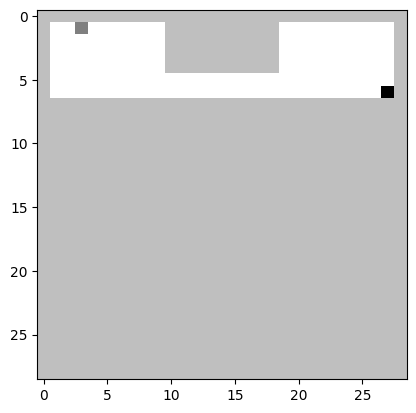

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


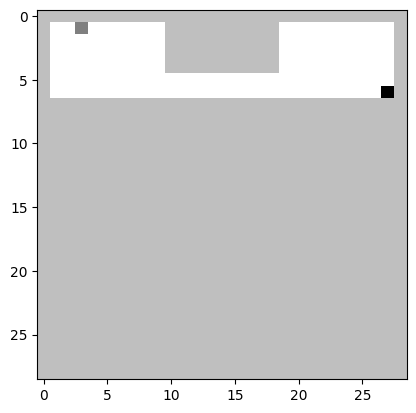

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


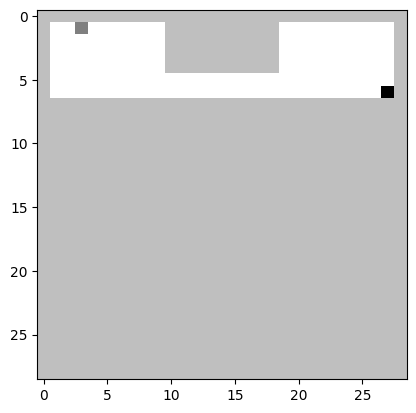

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


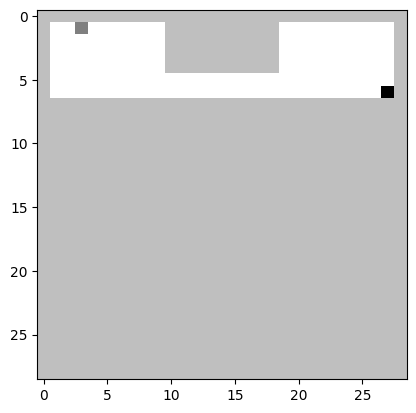

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


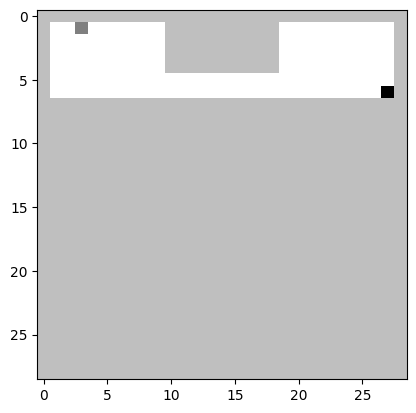

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


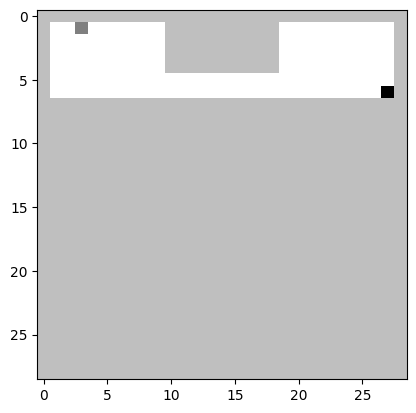

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


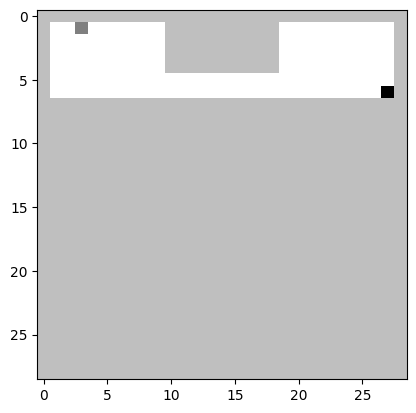

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


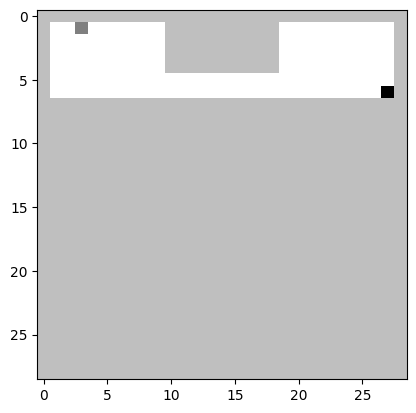

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


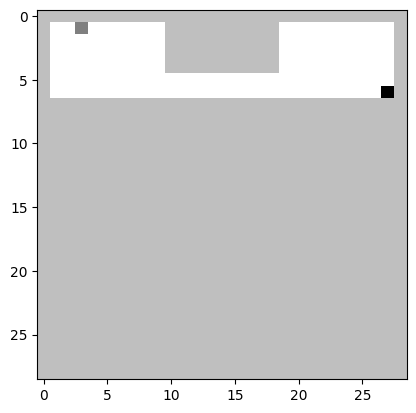

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


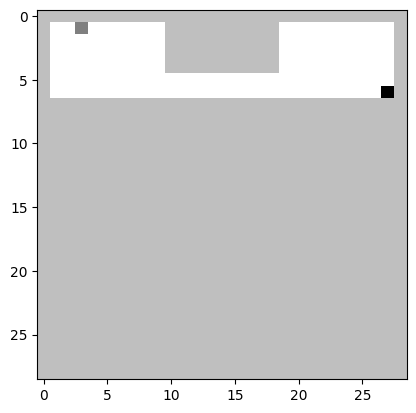

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


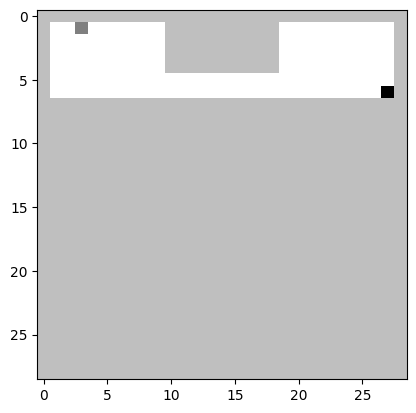

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


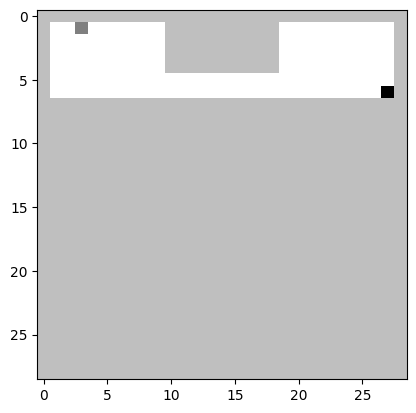

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


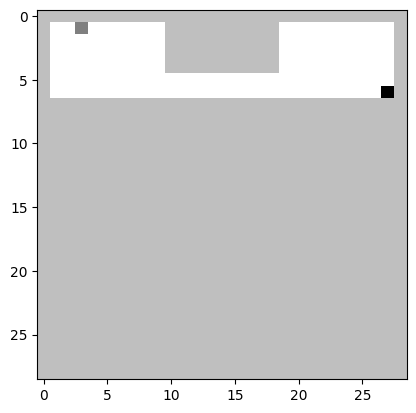

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


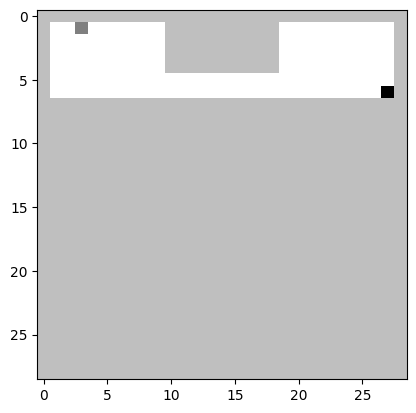

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


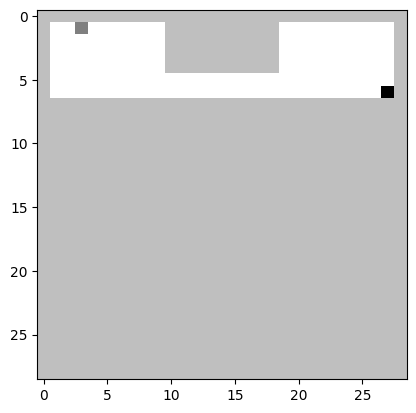

State:  ((1, 3, 0), (9, 2))
Chosen action:  0
Next state:  ((1, 3, 0), (9, 2))
argmaxstate ((1, 3, 0), (4, 2))
argmax and max Belief:  (4, 2) tensor(0.1667)


np.float64(-25.0)

In [6]:
evaluate_agent_training(env, agent,1,render=True)
